In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
import xgboost as xg
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
price_data_full = pd.read_csv("price_features_final_v2.csv")

In [3]:
price_data_full.head()

,Date,Hour,LMP,Energy_LMP,Loss_LMP,Congestion_LMP,TMP,GD Henry Hub,GD Houston ShipChl,GD Waha,...,Population,Z_GUADALAJARA,Z_MONTERREY,Z_VDM SUR,S_SPRING,S_SUMMER,S_WINTER,Year,Month,Day
0,2016-02-05,22,630.63,740.30,-67.07,-42.60,55.76,2.045,1.99,1.94,...,1036806,0,0,0,0,0,1,2016,2,5
1,2016-02-05,22,546.64,740.30,-58.11,-135.55,59.00,2.045,1.99,1.94,...,5341171,0,1,0,0,0,1,2016,2,5
2,2016-02-05,22,755.29,740.30,20.02,-5.03,73.94,2.045,1.99,1.94,...,21804515,0,0,1,0,0,1,2016,2,5
3,2016-02-06,1,590.27,676.79,-86.52,0.00,56.66,2.085,2.02,1.94,...,1036806,0,0,0,0,0,1,2016,2,6
4,2016-02-06,1,633.59,676.79,-43.19,0.00,60.08,2.085,2.02,1.94,...,5341171,0,1,0,0,0,1,2016,2,6


In [4]:
price_data_full['Date']= pd.to_datetime(price_data_full['Date'])
price_data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43703 entries, 0 to 43702
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                43703 non-null  datetime64[ns]
 1   Hour                43703 non-null  int64         
 2   LMP                 43703 non-null  float64       
 3   Energy_LMP          43703 non-null  float64       
 4   Loss_LMP            43703 non-null  float64       
 5   Congestion_LMP      43703 non-null  float64       
 6   TMP                 43703 non-null  float64       
 7   GD Henry Hub        43703 non-null  float64       
 8   GD Houston ShipChl  43703 non-null  float64       
 9   GD Waha             43703 non-null  float64       
 10  TotalMWh            43703 non-null  float64       
 11  LATITUDE            43703 non-null  float64       
 12  LONGITUDE           43703 non-null  float64       
 13  HDD                 43703 non-null  float64   

In [5]:
price_data_full["Time"] = price_data_full['Hour'] - 1

In [6]:
price_data_full["DateTime"] = pd.to_datetime(price_data_full.Date) + price_data_full.Time.astype('timedelta64[h]')

In [7]:
price_data_full.sort_values(by='DateTime', inplace = True)
price_data_full.reset_index(drop = True, inplace = True)
price_data_full.head()

,Date,Hour,LMP,Energy_LMP,Loss_LMP,Congestion_LMP,TMP,GD Henry Hub,GD Houston ShipChl,GD Waha,...,Z_MONTERREY,Z_VDM SUR,S_SPRING,S_SUMMER,S_WINTER,Year,Month,Day,Time,DateTime
0,2016-01-29,1,744.88,773.97,-28.85,-0.25,66.56,2.12,2.105,2.0,...,1,0,0,0,1,2016,1,29,0,2016-01-29 00:00:00
1,2016-01-29,1,804.09,773.97,30.33,-0.22,66.92,2.12,2.105,2.0,...,0,0,0,0,1,2016,1,29,0,2016-01-29 00:00:00
2,2016-01-29,1,726.79,773.97,-40.49,-6.69,59.18,2.12,2.105,2.0,...,0,0,0,0,1,2016,1,29,0,2016-01-29 00:00:00
3,2016-01-29,1,786.96,773.97,12.96,0.03,54.68,2.12,2.105,2.0,...,0,1,0,0,1,2016,1,29,0,2016-01-29 00:00:00
4,2016-01-29,4,461.63,479.40,-15.87,-1.90,46.40,2.12,2.105,2.0,...,0,0,0,0,1,2016,1,29,3,2016-01-29 03:00:00


In [8]:
price_data = price_data_full[(price_data_full['Z_GUADALAJARA'] == 1)]
price_data.reset_index(inplace = True, drop = True)

In [9]:
price_data.head()

,Date,Hour,LMP,Energy_LMP,Loss_LMP,Congestion_LMP,TMP,GD Henry Hub,GD Houston ShipChl,GD Waha,...,Z_MONTERREY,Z_VDM SUR,S_SPRING,S_SUMMER,S_WINTER,Year,Month,Day,Time,DateTime
0,2016-01-29,1,804.09,773.97,30.33,-0.22,66.92,2.12,2.105,2.0,...,0,0,0,0,1,2016,1,29,0,2016-01-29 00:00:00
1,2016-01-29,16,900.95,862.95,38.21,-0.21,41.90,2.12,2.105,2.0,...,0,0,0,0,1,2016,1,29,15,2016-01-29 15:00:00
2,2016-01-29,19,875.36,842.26,32.45,0.65,62.96,2.12,2.105,2.0,...,0,0,0,0,1,2016,1,29,18,2016-01-29 18:00:00
3,2016-01-29,22,886.29,844.06,30.48,11.76,72.14,2.12,2.105,2.0,...,0,0,0,0,1,2016,1,29,21,2016-01-29 21:00:00
4,2016-01-30,1,673.22,648.47,24.74,0.00,70.16,2.12,2.105,2.0,...,0,0,0,0,1,2016,1,30,0,2016-01-30 00:00:00


In [10]:
price_data.columns

Index(['Date', 'Hour', 'LMP', 'Energy_LMP', 'Loss_LMP', 'Congestion_LMP',
       'TMP', 'GD Henry Hub', 'GD Houston ShipChl', 'GD Waha', 'TotalMWh',
       'LATITUDE', 'LONGITUDE', 'HDD', 'CDD', 'Population', 'Z_GUADALAJARA',
       'Z_MONTERREY', 'Z_VDM SUR', 'S_SPRING', 'S_SUMMER', 'S_WINTER', 'Year',
       'Month', 'Day', 'Time', 'DateTime'],
      dtype='object')

In [11]:
prices = price_data
price_data = price_data.drop(['Date'], axis = 1)
price_new = prices.drop(['Date','Hour','Energy_LMP', 'Loss_LMP', 'Congestion_LMP',
       'TMP', 'GD Henry Hub', 'GD Houston ShipChl', 'GD Waha', 'TotalMWh',
       'LATITUDE', 'LONGITUDE', 'HDD', 'CDD', 'Population', 'Z_GUADALAJARA',
       'Z_MONTERREY', 'Z_VDM SUR', 'S_SPRING', 'S_SUMMER', 'S_WINTER', 'Year',
       'Month', 'Day','Time'], axis = 1)

In [12]:
price_new.head()

,LMP,DateTime
0,804.09,2016-01-29 00:00:00
1,900.95,2016-01-29 15:00:00
2,875.36,2016-01-29 18:00:00
3,886.29,2016-01-29 21:00:00
4,673.22,2016-01-30 00:00:00


In [13]:
X = price_data.drop(['DateTime','LMP','Energy_LMP','Loss_LMP','Congestion_LMP','LATITUDE', 'LONGITUDE','Population','HDD','Year','Z_GUADALAJARA','Z_MONTERREY', 'Z_VDM SUR', 'Time'], axis = 1)
y = price_data['LMP']

In [14]:
#len_data = 9108
#test_lowerlim = 7000
#test_upperlim = test_lowerlim + 48
#price_new = price_new[test_lowerlim:test_upperlim]
#X_train1= X[:test_lowerlim]
#X_train2 = X[test_upperlim:]
#X_train = pd.concat([X_train1,X_train2])
#X_test = X[test_lowerlim:test_upperlim]
#y_train1= y[:test_lowerlim]
#y_train2 = y[test_upperlim:]
#y_train = pd.concat([y_train1,y_train2])
#y_test = y[test_lowerlim:test_upperlim]

In [15]:
#X_train = X[:7000]
#y_train = y[:7000]
#X_test = X[7000:]
#y_test = y[7000:]
#price_new = price_new[7000:]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, test_size=0.2, 
                                                    random_state=42)

test_index = X_test.index

In [17]:
price_new = price_new.iloc[test_index]


# Scaling

In [18]:
from sklearn.preprocessing import RobustScaler


scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Extra Trees Regressor

### Base Model

In [19]:
etr = ensemble.ExtraTreesRegressor(n_estimators=400,random_state=42,max_depth=24,max_features='sqrt')
etr.fit(X_train, y_train) 
y_pred = etr.predict(X_test)
y_trainpred = etr.predict(X_train)

etr.score(X_test, y_test)

0.7761729714443928

###  RandomizedSearchCV

In [20]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
rcv_grid_params = {
        'n_estimators': n_est,
        'max_depth': [2,8,16,24,32,50],
        'min_samples_split':np.arange(2,15),
        'min_samples_leaf':[1,2,4],
        'max_features': ['auto', 'sqrt','log2'],
        'bootstrap':[True,False]
}
rcv_grid_params

{'n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'max_depth': [2, 8, 16, 24, 32, 50],
 'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 'min_samples_leaf': [1, 2, 4],
 'max_features': ['auto', 'sqrt', 'log2'],
 'bootstrap': [True, False]}

In [21]:
etr = ensemble.ExtraTreesRegressor()
etr_rcv= RandomizedSearchCV(etr, param_distributions=rcv_grid_params, n_iter = 150, cv=5, random_state = 42, n_jobs=-1)
etr_rcv.fit(X_train,y_train)


RandomizedSearchCV(cv=5, estimator=ExtraTreesRegressor(), n_iter=150, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 8, 16, 24, 32, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_estimators': [10, 12, 16, 20, 26, 33,
                                                         42, 54, 69, 88, 112,
                                                         143, 183, 233, 297,
                                                         379, 483, 615, 784,
                                                         1000]},
                   random_state=42)

In [22]:
print("Best Score:" + str(etr_rcv.best_score_))
print("Best Parameters: " + str(etr_rcv.best_params_))

Best Score:0.7128783808249266
Best Parameters: {'n_estimators': 143, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': False}


### GridSearchCV

In [20]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=10)]
grid_params = {
        'n_estimators': n_est,
        'max_depth': [2,10,24,36,50],
        'min_samples_split':np.arange(2,15,2),
}
grid_params

{'n_estimators': [10, 16, 27, 46, 77, 129, 215, 359, 599, 1000],
 'max_depth': [2, 10, 24, 36, 50],
 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14])}

In [21]:
etr = ensemble.ExtraTreesRegressor()
etr_cv= GridSearchCV(etr, param_grid=grid_params, cv=5, n_jobs=-1)
etr_cv.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=ExtraTreesRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 10, 24, 36, 50],
                         'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14]),
                         'n_estimators': [10, 16, 27, 46, 77, 129, 215, 359,
                                          599, 1000]})

In [22]:
print("Best Score:" + str(etr_cv.best_score_))
print("Best Parameters: " + str(etr_cv.best_params_))

Best Score:0.7404973192963132
Best Parameters: {'max_depth': 36, 'min_samples_split': 2, 'n_estimators': 1000}


### Model after tuning

In [19]:
etr = ensemble.ExtraTreesRegressor(n_estimators=400,random_state=42,max_depth=24,max_features='sqrt')
etr.fit(X_train, y_train) 
y_pred = etr.predict(X_test)
y_trainpred = etr.predict(X_train)

etr.score(X_test, y_test)

0.7761729714443928

In [20]:
y_test1 = np.zeros(len(y_test))
y_train1 = np.zeros(len(y_train))

print('The rmse of test prediction is:', (mean_squared_error(y_test, y_pred)
/mean_squared_error(y_test, y_test1))** 0.5)
print('The rmse of train prediction is:', (mean_squared_error(y_train, y_trainpred)
/mean_squared_error(y_train, y_train1))** 0.5)

The rmse of test prediction is: 0.2286056660721781
The rmse of train prediction is: 0.015241273556800158


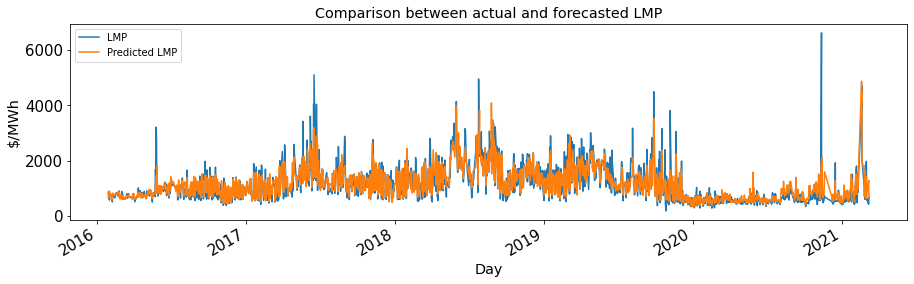

In [21]:
price_new['Predicted LMP']= y_pred

price_new = price_new.set_index('DateTime')
price_new.plot(legend=True, figsize=(15,4))
plt.xlabel('Day',fontsize='x-large')
plt.ylabel('$/MWh',fontsize='x-large')
plt.title('Comparison between actual and forecasted LMP',fontsize='x-large')
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

In [22]:
price_new

,LMP,Predicted LMP
DateTime,,
2020-05-16 21:00:00,605.34,660.728427
2020-12-09 15:00:00,530.70,666.419265
2018-04-16 03:00:00,554.28,802.962378
2020-02-27 18:00:00,586.34,679.833712
2017-11-23 00:00:00,910.76,984.680187
...,...,...
2017-08-06 06:00:00,819.93,900.596939
2019-08-20 06:00:00,1355.85,1263.508983
2019-02-02 12:00:00,1215.89,1215.739141


In [23]:
feature_importances = pd.DataFrame(etr.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [24]:
feature_importances

,importance
TotalMWh,0.220136
GD Henry Hub,0.184256
GD Houston ShipChl,0.167102
GD Waha,0.108591
Day,0.077192
Month,0.056033
TMP,0.052646
Hour,0.050432
CDD,0.041645
S_WINTER,0.015366


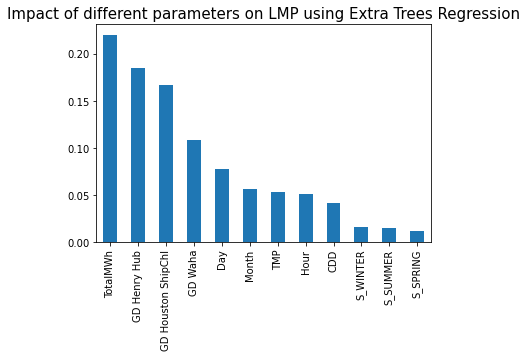

<Figure size 432x288 with 0 Axes>

In [25]:
feature_importances.plot(kind='bar',rot=10,legend=False)
plt.title('Impact of different parameters on LMP using Extra Trees Regression',fontsize=15)
plt.xticks(rotation = 90) 
plt.show()
plt.savefig('Extrafeatimp.png')

# Random Forest Regressor

### Base Model

In [209]:
rfr = ensemble.RandomForestRegressor(random_state=42,n_estimators=100)
rfr.fit(X_train, y_train) 
y_pred = rfr.predict(X_test)
y_trainpred = rfr.predict(X_train)

rfr.score(X_test, y_test)

0.8157317470909065

###  RandomizedSearchCV

In [34]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
rcv_grid_params = {
        'n_estimators': n_est,
        'max_depth': [2,8,16,24,32,50],
        'min_samples_split':np.arange(2,15),
        'min_samples_leaf':[1,2,4],
        'max_features': ['auto', 'sqrt','log2'],
        'bootstrap':[True,False]
}
rcv_grid_params

{'n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'max_depth': [2, 8, 16, 24, 32, 50],
 'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 'min_samples_leaf': [1, 2, 4],
 'max_features': ['auto', 'sqrt', 'log2'],
 'bootstrap': [True, False]}

In [35]:
rfr = ensemble.RandomForestRegressor()
rfr_rcv= RandomizedSearchCV(rfr, param_distributions=rcv_grid_params, n_iter = 150, cv=5, random_state = 42, n_jobs=-1)
rfr_rcv.fit(X_train,y_train)


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=150,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 8, 16, 24, 32, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_estimators': [10, 12, 16, 20, 26, 33,
                                                         42, 54, 69, 88, 112,
                                                         143, 183, 233, 297,
                                                         379, 483, 615, 784,
                                                         1000]},
                   random_state=42)

In [36]:
print("Best Score:" + str(rfr_rcv.best_score_))
print("Best Parameters: " + str(rfr_rcv.best_params_))

Best Score:0.7575582655956569
Best Parameters: {'n_estimators': 54, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 24, 'bootstrap': False}


### GridSearchCV

In [37]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=10)]
grid_params = {
        'n_estimators': n_est,
        'max_depth': [2,10,24,36,50],
        'min_samples_split':np.arange(2,15,2),
}
grid_params

{'n_estimators': [10, 16, 27, 46, 77, 129, 215, 359, 599, 1000],
 'max_depth': [2, 10, 24, 36, 50],
 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14])}

In [38]:
rfr = ensemble.RandomForestRegressor()
rfr_cv= GridSearchCV(rfr, param_grid=grid_params, cv=5, n_jobs=-1)
rfr_cv.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 10, 24, 36, 50],
                         'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14]),
                         'n_estimators': [10, 16, 27, 46, 77, 129, 215, 359,
                                          599, 1000]})

In [39]:
print("Best Score:" + str(rfr_cv.best_score_))
print("Best Parameters: " + str(rfr_cv.best_params_))

Best Score:0.7316499612973502
Best Parameters: {'max_depth': 50, 'min_samples_split': 2, 'n_estimators': 129}


### Model after tuning

In [26]:
rfr = ensemble.RandomForestRegressor(random_state=42,n_estimators=100)
rfr.fit(X_train, y_train) 
y_pred = rfr.predict(X_test)
y_trainpred = rfr.predict(X_train)

rfr.score(X_test, y_test)

0.8157317470909065

In [27]:
y_test1 = np.zeros(len(y_test))
y_train1 = np.zeros(len(y_train))

print('The rmse of test prediction is:', (mean_squared_error(y_test, y_pred)
/mean_squared_error(y_test, y_test1))** 0.5)
print('The rmse of train prediction is:', (mean_squared_error(y_train, y_trainpred)
/mean_squared_error(y_train, y_train1))** 0.5)

The rmse of test prediction is: 0.2074225575315951
The rmse of train prediction is: 0.09310382723134668


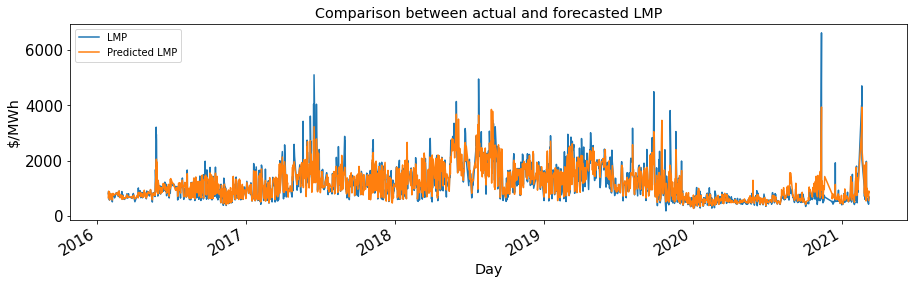

In [28]:
price_new = prices.drop(['Date','Hour','Energy_LMP', 'Loss_LMP', 'Congestion_LMP',
       'TMP', 'GD Henry Hub', 'GD Houston ShipChl', 'GD Waha', 'TotalMWh',
       'LATITUDE', 'LONGITUDE', 'HDD', 'CDD', 'Population', 'Z_GUADALAJARA',
       'Z_MONTERREY', 'Z_VDM SUR', 'S_SPRING', 'S_SUMMER', 'S_WINTER', 'Year',
       'Month', 'Day', 'Time'], axis = 1)

#price_new = price_new[7000:]
#price_new = price_new[test_lowerlim:test_upperlim]
price_new = price_new.iloc[test_index]
price_new['Predicted LMP']= y_pred

price_new = price_new.set_index('DateTime')
price_new.plot(legend=True,  figsize=(15,4))
plt.xlabel('Day',fontsize='x-large')
plt.ylabel('$/MWh',fontsize='x-large')
plt.title('Comparison between actual and forecasted LMP',fontsize='x-large')
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

In [29]:
price_new

,LMP,Predicted LMP
DateTime,,
2020-05-16 21:00:00,605.34,606.8362
2020-12-09 15:00:00,530.70,804.3316
2018-04-16 03:00:00,554.28,746.8143
2020-02-27 18:00:00,586.34,596.2516
2017-11-23 00:00:00,910.76,1054.4254
...,...,...
2017-08-06 06:00:00,819.93,796.3621
2019-08-20 06:00:00,1355.85,1382.0694
2019-02-02 12:00:00,1215.89,1410.9902


In [30]:
feature_importances = pd.DataFrame(rfr.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [31]:
feature_importances

,importance
TotalMWh,0.314407
GD Henry Hub,0.250615
GD Waha,0.111147
GD Houston ShipChl,0.094611
Month,0.071067
Day,0.065429
TMP,0.032404
Hour,0.020678
CDD,0.019065
S_SUMMER,0.011369


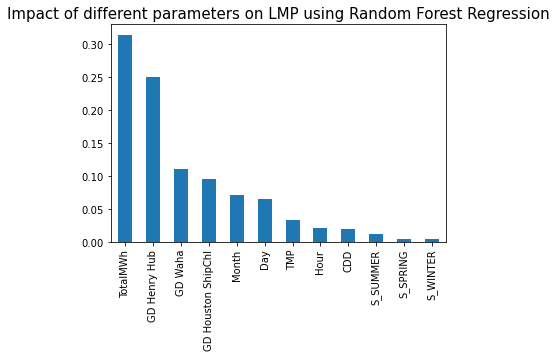

<Figure size 432x288 with 0 Axes>

In [32]:
feature_importances.plot(kind='bar',rot=10,legend=False)
plt.title('Impact of different parameters on LMP using Random Forest Regression',fontsize=15)
plt.xticks(rotation = 90) 
plt.show()
plt.savefig('RFfeatimp.png')

# Gradient Boosting Regressor

### Base Model 

In [47]:
gbr = ensemble.GradientBoostingRegressor(max_depth=12, max_features='log2',
 n_estimators= 400, subsample= 0.95,learning_rate=0.01)
gbr.fit(X_train, y_train) 
y_pred = gbr.predict(X_test)
y_trainpred = gbr.predict(X_train)

gbr.score(X_test, y_test)

0.799582917814342

###  RandomizedSearchCV 

In [48]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
rcv_grid_params = {
        'n_estimators': n_est,
        'max_depth': [2,8,12,16,24,32,50],
        'min_samples_split':np.arange(2,15),
        'min_samples_leaf':[1,2,4],
        'max_features': ['auto', 'sqrt','log2'],
        'subsample':[0.6,0.7,0.75,0.8,0.85,0.9],
        'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
}
rcv_grid_params

{'n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'max_depth': [2, 8, 12, 16, 24, 32, 50],
 'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 'min_samples_leaf': [1, 2, 4],
 'max_features': ['auto', 'sqrt', 'log2'],
 'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

In [49]:
gbr = ensemble.GradientBoostingRegressor(random_state=42)
gbr_rcv= RandomizedSearchCV(gbr, param_distributions=rcv_grid_params, n_iter = 150, cv=5, random_state = 42, n_jobs=-1)
gbr_rcv.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=150, n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.2, 0.3],
                                        'max_depth': [2, 8, 12, 16, 24, 32, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_estimators': [10, 12, 16, 20, 26, 33,
                                                         42, 54, 69, 88, 112,
                                                         143, 183, 233, 297,
                                                         379, 483, 615, 784,


In [50]:
print("Best Score:" + str(gbr_rcv.best_score_))
print("Best Parameters: " + str(gbr_rcv.best_params_))

Best Score:0.7805009043196002
Best Parameters: {'subsample': 0.85, 'n_estimators': 784, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 24, 'learning_rate': 0.01}


### GridSearchCV

In [51]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'n_estimators': n_est,
        'max_depth': [2,12,24,32,50],
        #'min_samples_split':np.arange(2,15),
        #'min_samples_leaf':[1,2,4],
        'max_features': ['auto', 'sqrt','log2'],
        'subsample':[0.7,0.8,0.9],
        'learning_rate':[0.0001, 0.01, 0.1, 0.3]
}
grid_params

{'n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'max_depth': [2, 12, 24, 32, 50],
 'max_features': ['auto', 'sqrt', 'log2'],
 'subsample': [0.7, 0.8, 0.9],
 'learning_rate': [0.0001, 0.01, 0.1, 0.3]}

In [52]:
gbr = ensemble.GradientBoostingRegressor()
gbr_cv= GridSearchCV(gbr, param_grid=grid_params, cv=5, n_jobs=-1)
gbr_cv.fit(X_train,y_train)


C:\Users\Zach Barrera\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.01, 0.1, 0.3],
                         'max_depth': [2, 12, 24, 32, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 12, 16, 20, 26, 33, 42, 54, 69,
                                          88, 112, 143, 183, 233, 297, 379, 483,
                                          615, 784, 1000],
                         'subsample': [0.7, 0.8, 0.9]})

In [53]:
print("Best Score:" + str(gbr_cv.best_score_))
print("Best Parameters: " + str(gbr_cv.best_params_))

Best Score:0.7772367176559125
Best Parameters: {'learning_rate': 0.01, 'max_depth': 12, 'max_features': 'log2', 'n_estimators': 1000, 'subsample': 0.9}


### Model after tuning

In [33]:
gbr = ensemble.GradientBoostingRegressor(max_depth=12, max_features='log2',
 n_estimators= 400, subsample= 0.95,learning_rate=0.01)
gbr.fit(X_train, y_train) 
y_pred = gbr.predict(X_test)
y_trainpred = gbr.predict(X_train)

gbr.score(X_test, y_test)

0.837300192835565

In [34]:
y_test1 = np.zeros(len(y_test))
y_train1 = np.zeros(len(y_train))

print('The rmse of test prediction is:', (mean_squared_error(y_test, y_pred)
/mean_squared_error(y_test, y_test1))** 0.5)
print('The rmse of train prediction is:', (mean_squared_error(y_train, y_trainpred)
/mean_squared_error(y_train, y_train1))** 0.5)

The rmse of test prediction is: 0.19490556743760198
The rmse of train prediction is: 0.0553170185217787


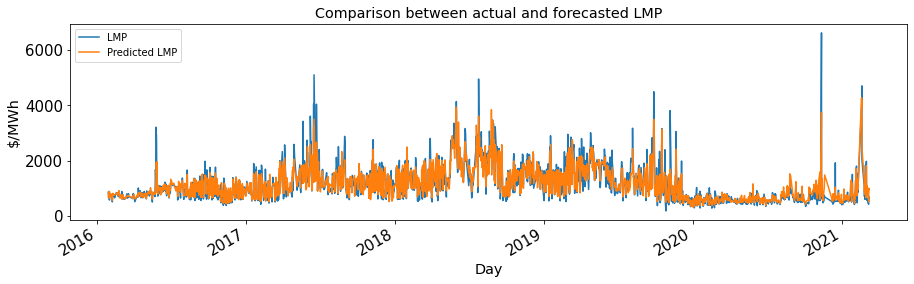

In [35]:
price_new = prices.drop(['Date','Hour','Energy_LMP', 'Loss_LMP', 'Congestion_LMP',
       'TMP', 'GD Henry Hub', 'GD Houston ShipChl', 'GD Waha', 'TotalMWh',
       'LATITUDE', 'LONGITUDE', 'HDD', 'CDD', 'Population', 'Z_GUADALAJARA',
       'Z_MONTERREY', 'Z_VDM SUR', 'S_SPRING', 'S_SUMMER', 'S_WINTER', 'Year',
       'Month', 'Day', 'Time'], axis = 1)

#price_new = price_new[7000:]
#price_new = price_new[test_lowerlim:test_upperlim]
price_new = price_new.iloc[test_index]
price_new['Predicted LMP']= y_pred

price_new = price_new.set_index('DateTime')
price_new.plot(legend=True, figsize=(15,4))
plt.xlabel('Day',fontsize='x-large')
plt.ylabel('$/MWh',fontsize='x-large')
plt.title('Comparison between actual and forecasted LMP',fontsize='x-large')
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

In [36]:
price_new

,LMP,Predicted LMP
DateTime,,
2020-05-16 21:00:00,605.34,681.929260
2020-12-09 15:00:00,530.70,624.756097
2018-04-16 03:00:00,554.28,747.987551
2020-02-27 18:00:00,586.34,612.576579
2017-11-23 00:00:00,910.76,1028.621140
...,...,...
2017-08-06 06:00:00,819.93,870.966305
2019-08-20 06:00:00,1355.85,1296.064298
2019-02-02 12:00:00,1215.89,1265.305324


In [37]:
feature_importances = pd.DataFrame(gbr.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [38]:
feature_importances

,importance
TotalMWh,0.240761
GD Henry Hub,0.187761
GD Houston ShipChl,0.169570
GD Waha,0.131633
Day,0.070004
Month,0.055774
TMP,0.040961
Hour,0.037944
CDD,0.028845
S_SUMMER,0.014882


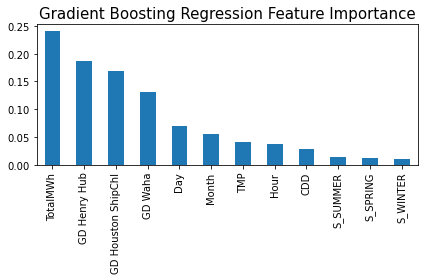

In [39]:
feature_importances.plot(kind='bar',rot=10,legend=False)
plt.title('Gradient Boosting Regression Feature Importance',fontsize=15)
plt.xticks(rotation = 90) 
plt.tight_layout()
plt.savefig('GBfeatimp.png')

# XGB Regressor

### Base Model

In [119]:
xgb =  xg.XGBRegressor(n_estimators=1400,
learning_rate=0.01,max_depth=17,gamma=5,subsample=0.85,
colsample_bytree = 0.85,min_child_weight=1)

xgb.fit(X_train, y_train) 
y_pred = xgb.predict(X_test)
y_trainpred = xgb.predict(X_train)

xgb.score(X_test, y_test)

0.85722824540855

###  RandomizedSearchCV

In [120]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
rcv_grid_params = {
        'n_estimators': n_est,
        'max_depth': [2,8,12,16,24,32,50],
        'colsample_bytree':[i/10.0 for i in range(6,10)],
        'gamma':[i/10.0 for i in range(0,5)],
        'min_child_weight':range(1,6,2),
        'subsample':[0.6,0.7,0.75,0.8,0.85,0.9],
        'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
}
rcv_grid_params

{'n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'max_depth': [2, 8, 12, 16, 24, 32, 50],
 'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
 'min_child_weight': range(1, 6, 2),
 'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

In [121]:
xgb = xg.XGBRegressor()
xgb_rcv= RandomizedSearchCV(xgb, param_distributions=rcv_grid_params, n_iter = 150, cv=5, random_state = 42, n_jobs=-1)
xgb_rcv.fit(X_train,y_train)

KeyboardInterrupt: 

In [64]:
print("Best Score:" + str(xgb_rcv.best_score_))
print("Best Parameters: " + str(xgb_rcv.best_params_))

Best Score:0.7931099499386426
Best Parameters: {'subsample': 0.9, 'n_estimators': 615, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0.4, 'colsample_bytree': 0.7}


### GridSearchCV

In [65]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=10)]
grid_params = {
        'n_estimators': n_est,
        #'max_depth': [2,8,12,16,24,32,50],
        #'colsample_bytree':[i/10.0 for i in range(6,10)],
        'gamma':[i/10.0 for i in range(0,5)],
        #'min_child_weight':range(1,6,2),
        #'subsample':[0.6,0.7,0.75,0.8,0.85,0.9],
        'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
}
grid_params

{'n_estimators': [10, 16, 27, 46, 77, 129, 215, 359, 599, 1000],
 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

In [66]:
xgb =  xg.XGBRegressor()
xgb_cv= GridSearchCV(xgb, param_grid=grid_params, cv=5, n_jobs=-1)
xgb_cv.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [67]:
print("Best Score:" + str(xgb_cv.best_score_))
print("Best Parameters: " + str(xgb_cv.best_params_))

Best Score:0.7838323673725542
Best Parameters: {'gamma': 0.4, 'learning_rate': 0.1, 'n_estimators': 1000}


### Model after tuning

In [40]:
xgb =  xg.XGBRegressor(n_estimators=1400,
learning_rate=0.01,max_depth=17,gamma=5,subsample=0.85,
colsample_bytree = 0.85,min_child_weight=1)

xgb.fit(X_train, y_train) 
y_pred = xgb.predict(X_test)
y_trainpred = xgb.predict(X_train)

xgb.score(X_test, y_test)

0.85722824540855

In [41]:
y_test1 = np.zeros(len(y_test))
y_train1 = np.zeros(len(y_train))

print('The rmse of test prediction is:', (mean_squared_error(y_test, y_pred)
/mean_squared_error(y_test, y_test1))** 0.5)
print('The rmse of train prediction is:', (mean_squared_error(y_train, y_trainpred)
/mean_squared_error(y_train, y_train1))** 0.5)

The rmse of test prediction is: 0.18257944144474067
The rmse of train prediction is: 0.002728009888238395


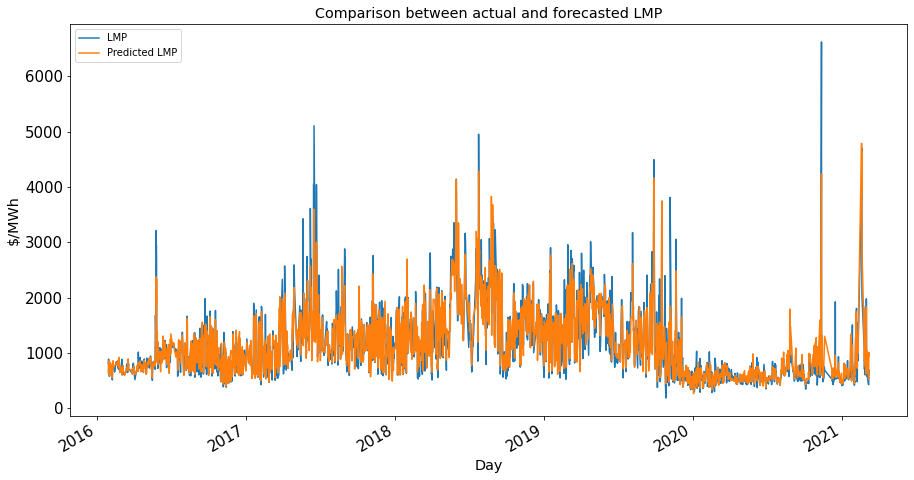

In [42]:
price_new = prices.drop(['Date','Hour','Energy_LMP', 'Loss_LMP', 'Congestion_LMP',
       'TMP', 'GD Henry Hub', 'GD Houston ShipChl', 'GD Waha', 'TotalMWh',
       'LATITUDE', 'LONGITUDE', 'HDD', 'CDD', 'Population', 'Z_GUADALAJARA',
       'Z_MONTERREY', 'Z_VDM SUR', 'S_SPRING', 'S_SUMMER', 'S_WINTER', 'Year',
       'Month', 'Day', 'Time'], axis = 1)

#price_new = price_new[7000:]
#price_new = price_new[test_lowerlim:test_upperlim]
price_new = price_new.iloc[test_index]
price_new['Predicted LMP']= y_pred

price_new = price_new.set_index('DateTime')
price_new.plot(legend=True, figsize=(15,8))
plt.xlabel('Day',fontsize='x-large')
plt.ylabel('$/MWh',fontsize='x-large')
plt.title('Comparison between actual and forecasted LMP',fontsize='x-large')
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('resultswhole.png')

In [43]:
price_new

,LMP,Predicted LMP
DateTime,,
2020-05-16 21:00:00,605.34,658.539734
2020-12-09 15:00:00,530.70,568.409607
2018-04-16 03:00:00,554.28,698.006836
2020-02-27 18:00:00,586.34,617.408142
2017-11-23 00:00:00,910.76,1032.577026
...,...,...
2017-08-06 06:00:00,819.93,850.518982
2019-08-20 06:00:00,1355.85,1328.549561
2019-02-02 12:00:00,1215.89,1313.223511


In [44]:
feature_importances = pd.DataFrame(xgb.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [45]:
feature_importances

,importance
Month,0.154656
GD Henry Hub,0.148613
S_SUMMER,0.138717
TotalMWh,0.132190
GD Houston ShipChl,0.094707
S_WINTER,0.087482
GD Waha,0.078250
S_SPRING,0.073450
Day,0.047789
Hour,0.018000


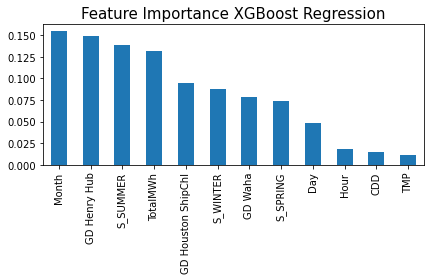

In [46]:
feature_importances.plot(kind='bar',rot=10,legend=False)
plt.title('Feature Importance XGBoost Regression',fontsize=15)
plt.xticks(rotation = 90) 
plt.tight_layout()
plt.savefig('XGBfeatimp.png')

## Analyzing results of best model

In [47]:
price_new["residuals"] = price_new["Predicted LMP"] - price_new["LMP"]
price_new

,LMP,Predicted LMP,residuals
DateTime,,,
2020-05-16 21:00:00,605.34,658.539734,53.199734
2020-12-09 15:00:00,530.70,568.409607,37.709607
2018-04-16 03:00:00,554.28,698.006836,143.726836
2020-02-27 18:00:00,586.34,617.408142,31.068142
2017-11-23 00:00:00,910.76,1032.577026,121.817026
...,...,...,...
2017-08-06 06:00:00,819.93,850.518982,30.588982
2019-08-20 06:00:00,1355.85,1328.549561,-27.300439
2019-02-02 12:00:00,1215.89,1313.223511,97.333511


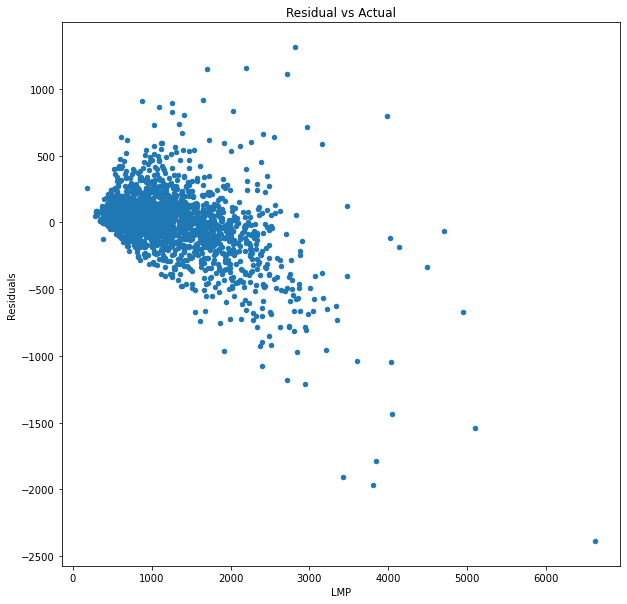

In [48]:
price_new.plot(x="LMP", y="residuals", kind = "scatter",figsize=(10,10))
plt.xlabel('LMP')
plt.ylabel('Residuals')
plt.title('Residual vs Actual')
plt.savefig('residualvactual.png')
plt.show()

In [49]:
price_new.sort_values(by='DateTime', inplace = True)
price_new

,LMP,Predicted LMP,residuals
DateTime,,,
2016-01-29 00:00:00,804.09,648.204773,-155.885227
2016-01-29 21:00:00,886.29,848.451416,-37.838584
2016-01-31 21:00:00,575.78,855.737122,279.957122
2016-02-01 12:00:00,709.36,586.719055,-122.640945
2016-02-02 15:00:00,816.38,817.590881,1.210881
...,...,...,...
2021-03-03 00:00:00,627.11,1049.747803,422.637803
2021-03-07 09:00:00,425.31,520.722290,95.412290
2021-03-07 12:00:00,449.18,536.773254,87.593254


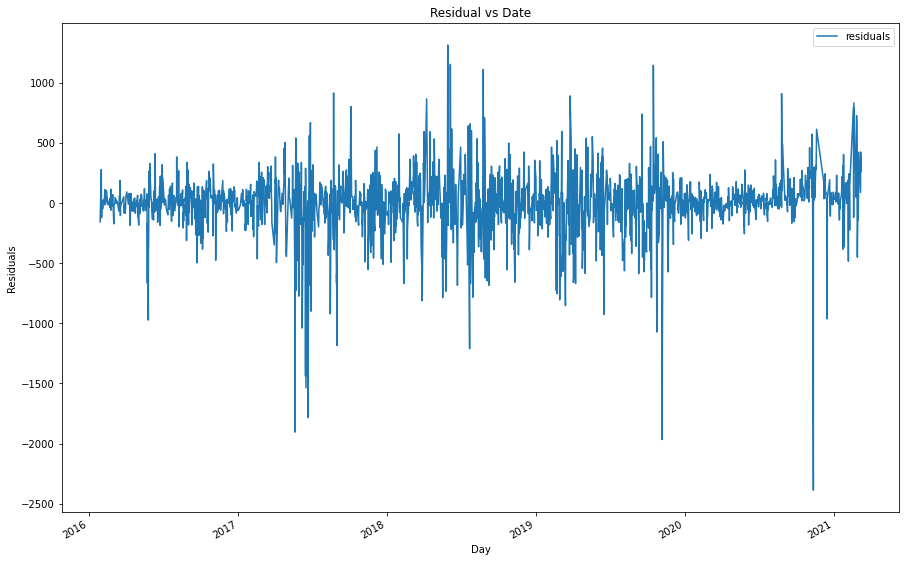

In [50]:
import matplotlib.dates as mdates
ax = price_new.plot(y="residuals",figsize=(15,10))
plt.xlabel('Day')
plt.ylabel('Residuals')
plt.title('Residual vs Date')

plt.savefig('residualvdate.png')
plt.show()

In [51]:
price_new["abs_residuals"] = price_new["residuals"].abs()
price_new

,LMP,Predicted LMP,residuals,abs_residuals
DateTime,,,,
2016-01-29 00:00:00,804.09,648.204773,-155.885227,155.885227
2016-01-29 21:00:00,886.29,848.451416,-37.838584,37.838584
2016-01-31 21:00:00,575.78,855.737122,279.957122,279.957122
2016-02-01 12:00:00,709.36,586.719055,-122.640945,122.640945
2016-02-02 15:00:00,816.38,817.590881,1.210881,1.210881
...,...,...,...,...
2021-03-03 00:00:00,627.11,1049.747803,422.637803,422.637803
2021-03-07 09:00:00,425.31,520.722290,95.412290,95.412290
2021-03-07 12:00:00,449.18,536.773254,87.593254,87.593254


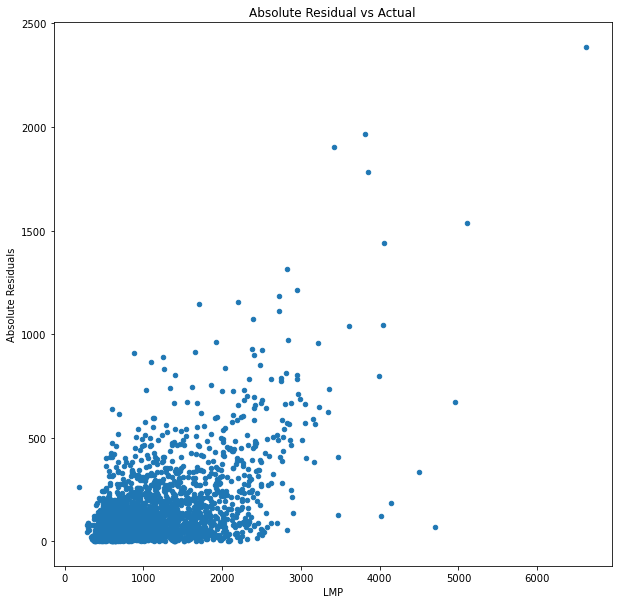

In [52]:
price_new.plot(x="LMP", y="abs_residuals", kind = "scatter",figsize=(10,10))
plt.xlabel('LMP')
plt.ylabel('Absolute Residuals')
plt.title('Absolute Residual vs Actual')
plt.savefig('absresidualvactual.png')
plt.show()

In [53]:
price_new.nlargest(20, 'abs_residuals')

,LMP,Predicted LMP,residuals,abs_residuals
DateTime,,,,
2020-11-11 21:00:00,6622.69,4235.837891,-2386.852109,2386.852109
2019-11-06 18:00:00,3812.09,1845.990967,-1966.099033,1966.099033
2017-05-20 18:00:00,3424.60,1520.469971,-1904.130029,1904.130029
2017-06-22 09:00:00,3847.92,2063.180176,-1784.739824,1784.739824
2017-06-16 15:00:00,5106.17,3569.568359,-1536.601641,1536.601641
2017-06-15 15:00:00,4051.01,2612.699951,-1438.310049,1438.310049
2018-05-30 09:00:00,2817.21,4131.621582,1314.411582,1314.411582
2018-07-23 00:00:00,2947.21,1736.694702,-1210.515298,1210.515298
2017-08-31 18:00:00,2717.88,1534.788086,-1183.091914,1183.091914


<AxesSubplot:>

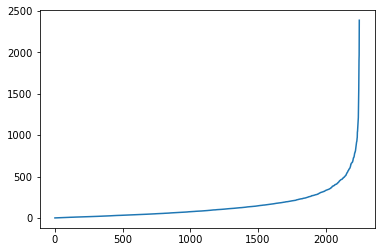

In [54]:
abs_res = price_new["abs_residuals"].sort_values().reset_index(drop = True)
abs_res.plot()

<AxesSubplot:>

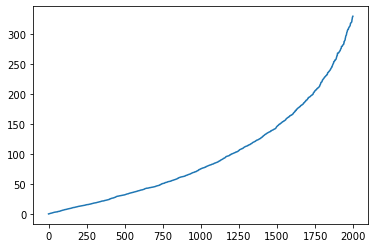

In [55]:
abs_res2 = abs_res.drop(abs_res.tail(250).index)
abs_res2.plot()

In [56]:
price_new.describe()

,LMP,Predicted LMP,residuals,abs_residuals
count,2249.000000,2249.000000,2249.000000,2249.000000
mean,1158.296012,1155.163940,-3.131854,149.311097
std,639.421018,569.996826,241.585881,189.920589
min,183.780000,260.757965,-2386.852109,0.005820
25%,679.970000,718.227966,-76.991660,36.599771
50%,988.860000,1027.565308,15.405106,88.578389
75%,1468.660000,1494.908325,100.454067,188.029077
max,6622.690000,4789.754395,1314.411582,2386.852109


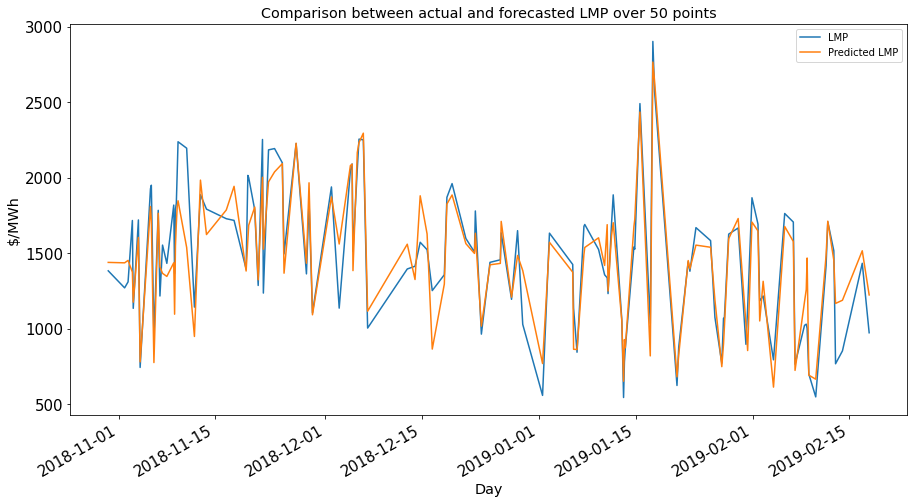

In [57]:
price_new_day = price_new[1250:1375]
price_new_day.plot(y = ["LMP","Predicted LMP"],legend=True, figsize=(15,8))
plt.xlabel('Day',fontsize='x-large')
plt.ylabel('$/MWh',fontsize='x-large')
plt.title('Comparison between actual and forecasted LMP over 50 points',fontsize='x-large')
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('resultsrand.png')

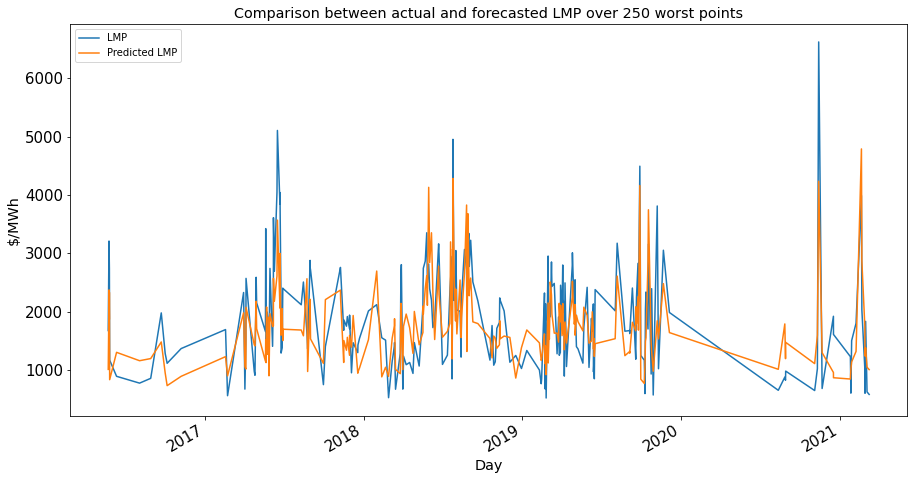

In [58]:
price_new_largestres = price_new.nlargest(250, 'abs_residuals')
price_new_largestres.plot(y = ["LMP","Predicted LMP"],legend=True, figsize=(15,8))
plt.xlabel('Day',fontsize='x-large')
plt.ylabel('$/MWh',fontsize='x-large')
plt.title('Comparison between actual and forecasted LMP over 250 worst points',fontsize='x-large')
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('resultsworst.png')

In [81]:
price_new_largestres.describe()

,LMP,Predicted LMP,residuals,abs_residuals
count,250.000000,250.000000,250.000000,250.000000
mean,1944.299320,1786.868408,-157.431247,563.288246
std,898.617696,688.812561,611.006733,282.215240
min,522.480000,734.282349,-2386.852109,330.467520
25%,1254.587500,1326.577515,-512.764094,391.050654
50%,1912.115000,1644.745850,-382.758604,472.677920
75%,2449.685000,2089.755554,405.498164,642.575031
max,6622.690000,4789.754395,1314.411582,2386.852109


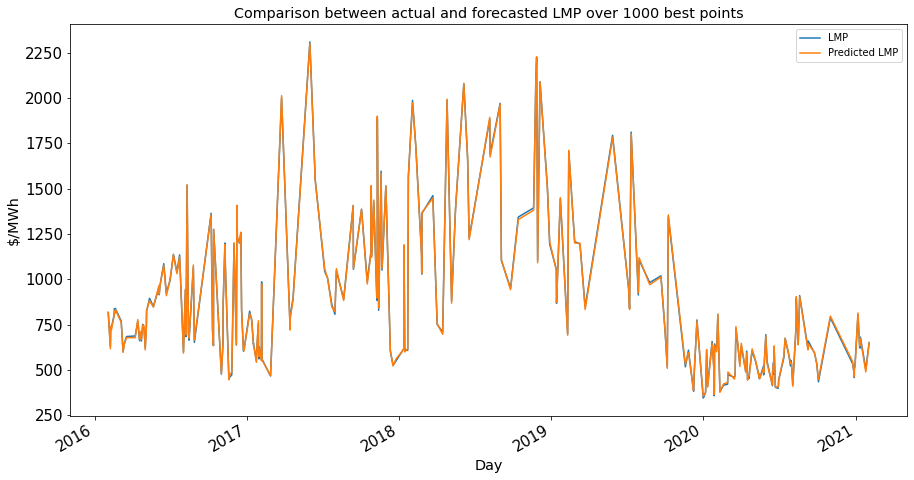

In [59]:
price_new_smallres = price_new.nsmallest(250, 'abs_residuals')
price_new_smallres.plot(y = ["LMP","Predicted LMP"],legend=True, figsize=(15,8))
plt.xlabel('Day',fontsize='x-large')
plt.ylabel('$/MWh',fontsize='x-large')
plt.title('Comparison between actual and forecasted LMP over 1000 best points',fontsize='x-large')
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('resultsbest.png')

In [60]:
price_new_smallres.describe()

,LMP,Predicted LMP,residuals,abs_residuals
count,250.000000,250.000000,250.000000,250.000000
mean,860.951600,861.041687,0.090206,7.944948
std,417.006137,415.916656,9.115232,4.440710
min,344.630000,354.714478,-15.170195,0.005820
25%,560.570000,563.019699,-8.154951,4.034659
50%,729.960000,726.836945,0.169039,8.170442
75%,1049.740000,1055.250671,8.103669,11.971117
max,2310.230000,2301.303955,15.405106,15.405106


In [72]:
data = [price_new_largestres["LMP"], price_new_smallres["LMP"]]

headers = ["Worst", "Best"]

df3 = pd.concat(data, axis=1, keys=headers)

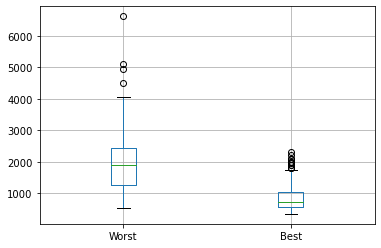

In [73]:
boxplot = df3.boxplot(column=['Worst', 'Best'])

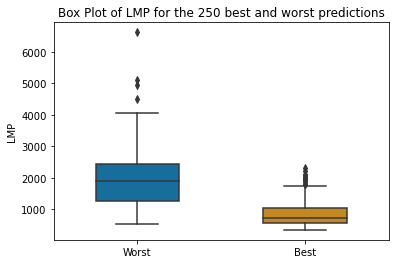

In [75]:
bplot = sns.boxplot(
                 data=df3, 
                 width=0.5,
                 palette="colorblind")
plt.ylabel('LMP')
plt.title('Box Plot of LMP for the 250 best and worst predictions')
plt.savefig('boxres.png')

In [145]:
price_new_smallres.index

DatetimeIndex(['2017-11-29 21:00:00', '2016-10-12 12:00:00',
               '2018-05-16 03:00:00', '2020-07-15 00:00:00',
               '2018-06-14 03:00:00', '2020-02-09 09:00:00',
               '2016-10-12 03:00:00', '2016-06-05 21:00:00',
               '2017-09-12 12:00:00', '2016-02-08 15:00:00',
               ...
               '2018-07-11 00:00:00', '2017-08-14 03:00:00',
               '2018-03-03 15:00:00', '2018-03-11 15:00:00',
               '2018-03-01 09:00:00', '2017-06-24 15:00:00',
               '2018-03-11 06:00:00', '2020-04-05 21:00:00',
               '2018-09-27 00:00:00', '2018-12-19 09:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=1000, freq=None)

In [146]:
prices = prices.set_index('DateTime')

In [147]:
prices_smallres = prices[prices.index.isin(price_new_smallres.index)]
prices_smallres.TotalMWh.describe()

count    1000.000000
mean     1046.055439
std       165.253753
min       631.904000
25%       911.675500
50%      1050.565500
75%      1182.400500
max      1412.652000
Name: TotalMWh, dtype: float64

In [148]:
prices_bigres = prices[prices.index.isin(price_new_largestres.index)]
prices_bigres.TotalMWh.describe()

count     250.000000
mean     1157.155556
std       154.737626
min       744.211000
25%      1041.416500
50%      1190.882500
75%      1273.552000
max      1514.292000
Name: TotalMWh, dtype: float64